# Google colab
* Выбрвать **File -> Save a copy in Drive**, нажмите **Open in new tab** во всплывающем окне, чтобы сохранить свой прогресс на Google Диске.
* Нажмите **Runtime -> Change runtime type** и выберите **GPU** в поле Аппаратный ускоритель (Hardware accelerator), чтобы включить ускоренное обучение на графической карте (GPU)

# Вариационный автокодировщик

Здесь мы создадим вариационный автокодировщик (autoencoder), обучите его на наборе данных MNIST и поиграете с его архитектурой и гиперпараметрами.


### Настройка
Загрузка вспомогательных файлов и импорт необходимых библиотек.

In [ ]:
#%pip install tensorflow

In [ ]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate, BatchNormalization
from keras.models import Model, Sequential
from keras import metrics
from keras.datasets import mnist
from keras.utils import np_utils

import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

### Вариационный автокодировщик

Напомним, что вариационный автоэнкодер — это вероятностная модель данных, основанная на непрерывной смеси распределений. В лекции мы рассмотрели случай смеси гауссиан, но здесь мы применим ВА (VAE) к бинарным изображениям MNIST (каждый пиксель либо черный, либо белый). Чтобы лучше моделировать двоичные данные, мы будем использовать непрерывную смесь биномиальных распределений: $$p(x \mid w) = \int p(x \mid t, w) p(t) dt,$$ где априорное распределение скрытой переменной $t$ — стандартное нормальное $p(t) = \mathcal{N}(t\mid 0, I)$, но вероятность того, что $(i, j)$-й пиксель черный, равна $(i, j)$-му выходу нейронной сети декодера: $$p(x_{i, j} \mid t, w) = \text{decoder}(t, w)_{i, j}.$$

Чтобы обучить эту модель, мы хотели бы максимизировать неполное логарифмическое правдоподобие нашего набора данных $$\max_w \log p(X \mid w),$$ но это очень сложно сделать в вычислительном отношении, поэтому вместо этого мы максимизируем вариационную нижнюю границу  как для исходных параметров $w$, так и для распределений $q$, которое мы определяем как кодирующую нейронную сеть (encoder) с параметрами (весами) $\phi$, которая принимает входное изображение $x$ и выводит параметры гауссовского распределения $$q(t \mid x, \phi ): \log p(X \mid w) \geq \mathcal{L}(w, \phi) \rightarrow \max_{w, \phi}.$$

Итак, в целом наша модель выглядит следующим образом: кодировщик (encoder) берет изображение $x$, выдает распределение по скрытым кодам $q(t\mid x)$, которое должно аппроксимировать апостериорное распределение $p(t\mid x)$ (по крайней мере, после обучения), моделирует точку из этого распределения $\widehat{t} \sim q(t \mid x, \phi)$ и, наконец, передает ее в декодер, который выводит распределение над изображениями.

![](https://github.com/hse-aml/bayesian-methods-for-ml/blob/master/week5/VAE.png?raw=1)

В лекции мы также обсудили, что вариационная нижняя граница имеет математическое ожидание, которое мы собираемся аппроксимировать усреднением по выборкам. Но это не тривиально, поскольку нам нужно дифференцировать это приближение. Тем не менее, мы узнали о трюке _репараметризации_, который предлагает вместо выборки из распределения $\widehat{t} \sim q(t \mid x, \phi)$ брать выборку из распределения, которое не зависит ни от каких параметров, например, стандартное нормальное, а затем детерминистически преобразовать эту выборку в нужную: $$\varepsilon \sim \mathcal{N}(0, I),\quad \widehat{t} = m(x, \phi) + \varepsilon \sigma(x, \phi).$$ Таким образом, нам не нужно беспокоиться о смещении нашего стохастического градиента, и мы можем напрямую дифференцировать нашу функцию потерь  по всем параметрам, считая текущую выборку $\varepsilon$ постоянной.



### Отрицательная вариационная нижняя граница

**Задача 1** 
Получим вариационную нижнюю границу для непрерывной смеси биномиальных распределений.
$$
{\cal L(w,q)} = VLB =   \sum_{i=1}^N \text{VLB}_i =  \sum_i\mathbf{M}_{q_i}\log\frac{p(x_i\mid t_i, w) p(t_i)}{q_{i}(t_i)} = \sum_i \mathbf{M}_{q_i} \log p(x_i\mid t_i, w)  +  \underbrace{\mathbf{M}_{q_i}\log \frac{p(t_i)}{q_i(t_i)}}_{-D_{kl}(q_i(t_i)|| p(t_i))}
$$
$$
\begin{align*}
D_{kl}(q_i(t_i)|| p(t_i)) &= 
\\
&=\sum_{j=1}^M\left(-\log\sigma(t_i) + \frac{\sigma^2(t_i) +\mu^2(t_i)-1}{2}\right) = M\left(-\log\sigma(t_i) + \frac{\sigma^2(t_i) +\mu^2(t_i)-1}{2}
\right)
\end{align*}
$$
Первый член в выражении для ${\cal L(w,q)}$:
\begin{align*}
\sum_i\mathbf{M}_{q_i}\log p(x_i\mid t_i, w)  &= \sum_i \int q_i(t_i)\log \prod_j p_j(t_i)^{x_{ij}}(1-p_j(t_i))^{(1-x_{ij})}\,dt = 
\\
&= \sum_i \int q_i(t)\sum_jx_{ij} \log p_j(t_i) + (1-x_{ij})\log (1-p_j(t_i))\,dt = \sum_i\mathbf{M}_{q_i} BCE(x_i, p(t_i))
\end{align*}
где BCE — бинарная кросс-энтропия
$$
VLB_i =\mathbf{M}_{q_i}\left\{BCE(x_i, p(t_i)) + M\left(-\log\sigma(t_i) + \frac{\sigma^2(t_i) +\mu^2(t_i)-1}{2}\right)\right\}
$$


**Обратите внимание**, что в лекциях мы обсуждали максимизацию (Вариационная Нижняя Граница) VLB (обычно это отрицательное число), но в этом задании для удобства мы **минимизируем** **отрицательную** версию VLB (которая будет положительное число) вместо максимизации обычного VLB. В дальнейшем мы всегда будем говорить об _отрицательный_ VLB, даже если будем использовать термин VLB для краткости.


**Обратите внимание**, код будет работать с мини-пакетами любого размера.

Для этого нам нужна стохастическая оценка VLB:
$$\text{VLB} = \sum_{i=1}^N \text{VLB}_i \approx \frac{N}{M}\sum_{i_s}^M \text{VLB}_{i_s}$$
где $N$ — размер набора данных, $\text{VLB}_i$ — терм VLB, соответствующий $i$-му объекту, а $M$ — размер мини-пакета (mini-batch). Но вместо этой стохастической оценки полной VLB мы будем использовать оценку отрицателбной VLB, нормализованную по размеру набора данных, т.е. в приведенной ниже функции нужно вернуть среднее значение по мини-батчу $-\frac{1}{M} \sum_{i_s}^M \text{VLB}_{i_s}$. Обычно оптимизируют эту нормализованную версию VLB, поскольку она не зависит от набора данных — вы можете написать функцию VLB один раз и использовать ее для разных наборов данных — размер набора данных не слишком сильно повлияет на скорость обучения. Правильное значение для этой нормализованной отрицательнй VLB должен составлять около 100–170  в приведенном ниже примере.

In [29]:
def vlb_binomial(x, x_decoded_mean, t_mean, t_log_var):
    """Returns the value of negative Variational Lower Bound
    
    The inputs are tf.Tensor
        x: (batch_size x number_of_pixels) matrix with one image per row with zeros and ones
        x_decoded_mean: (batch_size x number_of_pixels) mean of the distribution p(x | t), real numbers from 0 to 1
        t_mean: (batch_size x latent_dim) mean vector of the (normal) distribution q(t | x)
        t_log_var: (batch_size x latent_dim) logarithm of the variance vector of the (normal) distribution q(t | x)
    
    Returns:
        A tf.Tensor with one element (averaged across the batch), VLB
    """
    cce = tf.keras.losses.CategoricalCrossentropy(axis=1)
    t_var =  tf.exp(t_log_var)
    kl = -t_log_var/2.0 + (t_var + t_mean**2 - 1)/2.0
    kl = tf.reduce_sum(kl, axis=1)
    log_p = -tf.keras.metrics.binary_crossentropy(x, x_decoded_mean)
    batch_size = x.shape[0]
    number_of_pixels = x.shape[1]
    latend_dim = t_mean.shape[1]
    result = tf.reduce_mean(number_of_pixels*log_p - kl) 
    print("batch_size = {}, number_of_pixels = {} kl_size = {}".format(batch_size, number_of_pixels, kl.shape))
    return -result

In [30]:
print("tf", tf.__version__)
print("keras", keras.__version__)

tf 2.8.0
keras 2.8.0


In [31]:
# Start tf session so we can run code.
#sess = tf.InteractiveSession()
sess=tf.compat.v1.InteractiveSession()
# Connect keras to the created session.
K.set_session(sess)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


## Определение Encoder / decoder 

**Задание 2**  Ниже приведен код, который  определяет энкодер и декодер, и реализуйт выборку с приемом репараметризации в предоставленном пространстве.

In [32]:
latent_dim = 3
batch_size = 6
_var =  tf.ones(shape=[batch_size, latent_dim])
_mean = tf.zeros(shape=[batch_size, latent_dim])
eps = tf.random.normal([1,2], mean=0, stddev=1, dtype=tf.float32)

In [33]:
batch_size = 100
original_dim = 784 # Number of pixels in MNIST images.
latent_dim = 10 # d, dimensionality of the latent code t.
intermediate_dim = 256 # Size of the hidden layer.
epochs = 10

x = Input(batch_shape=(batch_size, original_dim))
def create_encoder(input_dim):
    # Encoder network.
    # We instantiate these layers separately so as to reuse them later
    encoder = Sequential(name='encoder')
    encoder.add(InputLayer([input_dim]))
    encoder.add(Dense(intermediate_dim, activation='relu'))
    encoder.add(Dense(2 * latent_dim))
    return encoder

    
encoder = create_encoder(original_dim)

get_t_mean = Lambda(lambda h: h[:, :latent_dim])
get_t_log_var = Lambda(lambda h: h[:, latent_dim:])
h = encoder(x)
t_mean = get_t_mean(h)
t_log_var = get_t_log_var(h)

# Sampling from the distribution 
#     q(t | x) = N(t_mean, exp(t_log_var))
# with reparametrization trick.
def sampling(args):
    """Returns sample from a distribution N(args[0], diag(args[1]))
    
    The sample should be computed with reparametrization trick.
    
    The inputs are tf.Tensor
        args[0]: (batch_size x latent_dim) mean of the desired distribution
        args[1]: (batch_size x latent_dim) logarithm of the variance vector of the desired distribution
    
    Returns:
        A tf.Tensor of size (batch_size x latent_dim), the samples.
    """
    t_mean, t_log_var = args
    t_std = tf.exp(0.5*t_log_var)
    #print(t_std)
    eps = tf.random.normal(t_mean.shape, mean=0, stddev=1, dtype=tf.float32)*t_std + t_mean
    return eps

    # YOUR CODE HERE


t = Lambda(sampling)([t_mean, t_log_var])

def create_decoder(input_dim):
    # Decoder network
    # We instantiate these layers separately so as to reuse them later
    decoder = Sequential(name='decoder')
    decoder.add(InputLayer([input_dim]))
    decoder.add(Dense(intermediate_dim, activation='relu'))
    decoder.add(Dense(original_dim, activation='sigmoid'))
    return decoder

    
decoder = create_decoder(latent_dim)
x_decoded_mean = decoder(t)


## Обучение модели

**Задание 3** Запустите указанные ниже ячейки, чтобы обучить модель с настройками по умолчанию. Измените параметры, чтобы получить лучшие результаты. Особенно обратите внимание на архитектуру кодировщика/декодера (например, использование большего количества слоев, возможно, сделав их сверточными), скорость обучения и количество эпох.

batch_size = 100, number_of_pixels = 784 kl_size = (100,)


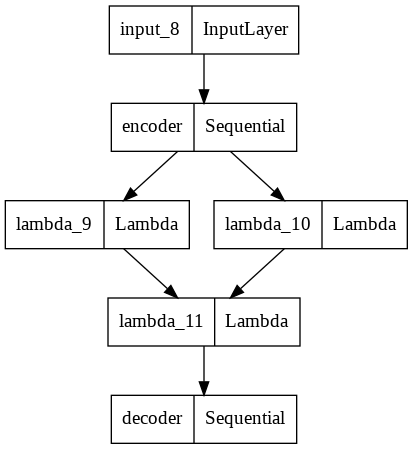

In [34]:
loss = vlb_binomial(x, x_decoded_mean, t_mean, t_log_var)
vae = Model(x, x_decoded_mean)
tf.keras.utils.plot_model(vae)

In [35]:

# Keras will provide input (x) and output (x_decoded_mean) to the function that
# should construct loss, but since our function also depends on other
# things (e.g. t_means), it is easier to build the loss in advance and pass
# a function that always returns it.
#vae.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss=lambda x, y: loss)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,\
                amsgrad=False, name='Adam'), loss=lambda x, y: loss)

#### Загрузка и подготовка данных

In [36]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# One hot encoding.
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

#### Обучение модели

In [37]:
#with tf.device('/GPU:0'):
hist = vae.fit(x=x_train, y=x_train,
               shuffle=True,
               epochs=epochs,
               batch_size=batch_size,
               validation_data=(x_test, x_test),
               verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


60000/60000 - 7s - loss: 166.1393 - val_loss: 134.1299 - 7s/epoch - 120us/sample
Epoch 2/10
60000/60000 - 7s - loss: 129.7432 - val_loss: 124.6246 - 7s/epoch - 113us/sample
Epoch 3/10
60000/60000 - 7s - loss: 123.3694 - val_loss: 120.3449 - 7s/epoch - 110us/sample
Epoch 4/10
60000/60000 - 7s - loss: 119.9923 - val_loss: 117.8118 - 7s/epoch - 111us/sample
Epoch 5/10
60000/60000 - 7s - loss: 117.8280 - val_loss: 116.0768 - 7s/epoch - 110us/sample
Epoch 6/10
60000/60000 - 7s - loss: 116.3670 - val_loss: 114.9136 - 7s/epoch - 110us/sample
Epoch 7/10
60000/60000 - 7s - loss: 115.2924 - val_loss: 113.9341 - 7s/epoch - 110us/sample
Epoch 8/10
60000/60000 - 7s - loss: 114.4142 - val_loss: 113.1014 - 7s/epoch - 109us/sample
Epoch 9/10
60000/60000 - 7s - loss: 113.7170 - val_loss: 112.7583 - 7s/epoch - 124us/sample
Epoch 10/10
60000/60000 - 7s - loss: 113.1379 - val_loss: 112.0588 - 7s/epoch - 109us/sample


### Визуализация реконструкции для обучения и проверки данных
На рисунке ниже вы можете увидеть способность вашей сети к реконструкции на основе данных обучения и валидации. В каждом из двух изображений левый столбец — это изображения MNIST, а правый столбец — это соответствующее изображение после прохождения через автоэнкодер (или, точнее, среднее значение биномиального распределения по выходным изображениям).

Обратите внимание, что получение наилучшей возможной реконструкции не является целью VAE, дивергенция Кульбака-Лейблера KL функции потерь ухудшает производительность реконструкции. Но реконструкция в любом случае должна быть разумной, и они предоставляют визуальный инструмент отладки кода.

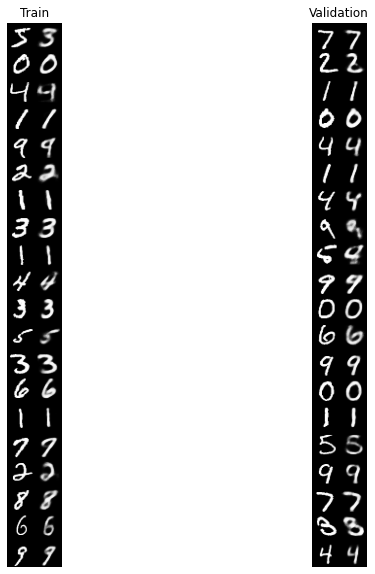

In [38]:
fig = plt.figure(figsize=(10, 10))
for fid_idx, (data, title) in enumerate(
            zip([x_train, x_test], ['Train', 'Validation'])):
    n = 20  # figure with 10 x 2 digits
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * 2))
    decoded = sess.run(x_decoded_mean, feed_dict={x: data[:batch_size, :]})
    for i in range(n):
        figure[i * digit_size: (i + 1) * digit_size,
               :digit_size] = data[i, :].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               digit_size:] = decoded[i, :].reshape(digit_size, digit_size)
    ax = fig.add_subplot(1, 2, fid_idx + 1)
    ax.imshow(figure, cmap='Greys_r')
    ax.set_title(title)
    ax.axis('off')
plt.show()

## Создание новых данных
**Задание 4** Написать код для создания новых образцов изображений из обученного VAE. Для этого нужно выбрать из априорного распределения $p(t)$, а затем из вероятности $p(x \mid t)$.

**Обратите внимание**, что выборка, которую вы записали в Задаче 2, относится к вариационному распределению $q(t \mid x)$, а здесь вам нужно взять исходную выборку.

In [ ]:
n_samples = 10  # To pass automatic grading please use at least 2 samples here.
# YOUR CODE HERE.
# ...
# sampled_im_mean is a tf.Tensor of size 10 x 784 with 10 random
# images sampled from the vae model.
_mean = tf.zeros([n_samples, original_dim], dtype=tf.float32)
_std =tf.ones([n_samples, original_dim], dtype=tf.float32)
t_samples = tf.random.normal([n_samples, latent_dim], mean=0, stddev=1, dtype=tf.float32)
sampled_im_mean = decoder(t_samples)

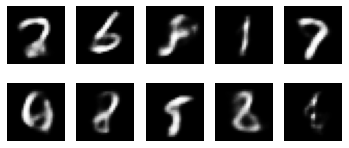

In [ ]:
sampled_im_mean_np = sess.run(sampled_im_mean)
# Show the sampled images.
plt.figure()
for i in range(n_samples):
    ax = plt.subplot(n_samples // 5 + 1, 5, i + 1)
    plt.imshow(sampled_im_mean_np[i, :].reshape(28, 28), cmap='gray')
    ax.axis('off')
plt.show()

# Условный VAE

В последнем задании мы изменним свой код, чтобы получить условный вариационный автоэнкодер [1]. Идея очень проста: чтобы иметь возможность контролировать сгенерированные вами выборки, мы обусловливаем все распределения некоторой дополнительной информацией. В нашем случае этой дополнительной информацией будет метка класса (цифра на изображении, от 0 до 9).

![](https://github.com/hse-aml/bayesian-methods-for-ml/blob/master/week5/CVAE.png?raw=1)

Итак, теперь и вероятность, и вариационное распределение зависят от метки класса: $p(x \mid t, \text{label}, w)$, $q(t \mid x, \text{label}, \phi )$.

Единственное, что вам нужно изменить в своем коде, это объединить входное изображение $x$ с (one-hot) меткой этого изображения для передачи в кодировщик $q$ и объединить скрытую переменную $t$ с той же меткой для передачи в декодер $p$. Обратите внимание, что это немного сложнее сделать со сверточной моделью кодера/декодера.

[1] Sohn, Kihyuk, Honglak Lee, and Xinchen Yan. “Learning Structured Output Representation using Deep Conditional Generative Models.” Advances in Neural Information Processing Systems. 2015.

## Последняя задача


**Задача 5.1** Здесь будет повторно внедрен CVAE модель, т.е. будут использованы  ```create_encoder``` и ```create_decoder```, определенные ранее (теперь вы можете понять, почему они принимают размер ввода в качестве аргумента ;) ). также будет использоваться слой Keras `concatenate` для объединения меток с входными данными и скрытым кодом.


In [24]:
# One-hot labels placeholder.

batch_size = 100
original_dim = 784 # Number of pixels in MNIST images.
latent_dim = 10 # d, dimensionality of the latent code t.
intermediate_dim = 256 # Size of the hidden layer.
epochs = 200

x = Input(batch_shape=(batch_size, original_dim))
label = Input(batch_shape=(batch_size, 10))

def create_encoder2(input_dim):
    # Encoder network.
    # We instantiate these layers separately so as to reuse them later
    encoder = Sequential(name='encoder2')
    encoder.add(InputLayer([input_dim]))
    encoder.add(Dense(intermediate_dim, activation='relu'))
    encoder.add(Dense(2 * latent_dim))
    return encoder

encoder2 = create_encoder2(original_dim + 10)

get_t_mean = Lambda(lambda h: h[:, :latent_dim])
get_t_log_var = Lambda(lambda h: h[:, latent_dim:])
get_x =  Lambda(lambda h: h[:, :original_dim])
h = encoder2(tf.concat([x,label], 1))
cond_t_mean = get_t_mean(h)
cond_t_log_var = get_t_log_var(h)

# Sampling from the distribution 
#     q(t | x) = N(t_mean, exp(t_log_var))
# with reparametrization trick.

t = Lambda(sampling)([cond_t_mean, cond_t_log_var])

def create_decoder2(input_dim):
    # Decoder network
    # We instantiate these layers separately so as to reuse them later
    decoder = Sequential(name='decoder2')
    decoder.add(InputLayer([input_dim]))
    decoder.add(Dense(intermediate_dim, activation='relu'))
    decoder.add(Dense(original_dim, activation='sigmoid'))
    return decoder
decoder2 = create_decoder2(latent_dim + 10)
x_decoded_mean = decoder2(tf.concat([t,label] ,1))
cond_x_decoded_mean = get_x(x_decoded_mean)


In [25]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# One hot encoding.
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

## Определение функции ошибки и модели

In [26]:
conditional_loss = vlb_binomial(x, cond_x_decoded_mean, cond_t_mean, cond_t_log_var)
cvae = Model([x, label], cond_x_decoded_mean)
cvae.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss=lambda x, y: conditional_loss)
#cvae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,\
#                amsgrad=False, name='Adam'), loss=lambda x, y: loss)
tf.keras.utils.plot_model(cvae)

TypeError: ignored

### Обучение модели

In [27]:
hist = cvae.fit(x=[x_train, y_train],
                y=x_train,
                shuffle=True,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=([x_test, y_test], x_test),
                verbose=2)

NameError: ignored

### Визуализация реконструкции для обучения и проверки данных

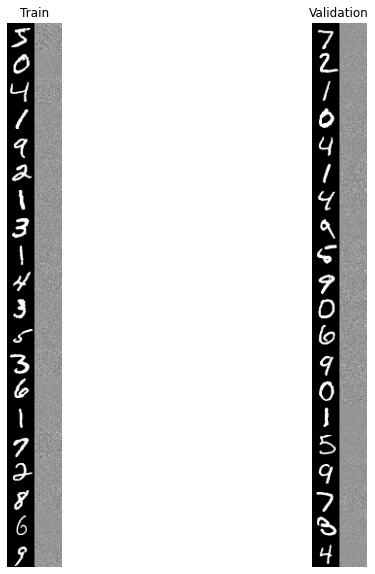

In [28]:
fig = plt.figure(figsize=(10, 10))
for fid_idx, (x_data, y_data, title) in enumerate(
            zip([x_train, x_test], [y_train, y_test], ['Train', 'Validation'])):
    n = 20  # figure with 10 x 2 digits
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * 2))
    decoded = sess.run(cond_x_decoded_mean,
                       feed_dict={x: x_data[:batch_size, :],
                                  label: y_data[:batch_size, :]})
    for i in range(n):
        figure[i * digit_size: (i + 1) * digit_size,
               :digit_size] = x_data[i, :].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               digit_size:] = decoded[i, :].reshape(digit_size, digit_size)
    ax = fig.add_subplot(1, 2, fid_idx + 1)
    ax.imshow(figure, cmap='Greys_r')
    ax.set_title(title)
    ax.axis('off')
plt.show()

## Условные новые данные

**Задание 5.2** Реализовать условное моделирование из распределения $p(x \mid t, \text{label})$, сначала выбирая из априорного $p(t)$, а затем выбирая из вероятности $p(x \mid т, \text{метка})$.

In [ ]:
# Prepare one hot labels of form
#   0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 ...
# to sample five zeros, five ones, etc
n_samples = 50
curr_labels = np.eye(10)
curr_labels = np.repeat(curr_labels, 5, axis=0)  # Its shape is 50 x 10.
# YOUR CODE HERE.
# ...
# cond_sampled_im_mean is a tf.Tensor of size 50 x 784 with 5 random zeros,
# then 5 random ones, etc sampled from the cvae model.
#curr_labels.tolist()

In [ ]:
_mean = tf.zeros([n_samples, original_dim], dtype=tf.float32)
_std =tf.ones([n_samples, original_dim], dtype=tf.float32)
t_samples = tf.random.normal([n_samples, latent_dim], mean=0, stddev=1, dtype=tf.float32)
curr_labels_tensor = tf.convert_to_tensor(curr_labels.tolist())
cond_sampled_im_mean = decoder2(tf.concat([t_samples, curr_labels_tensor],1))

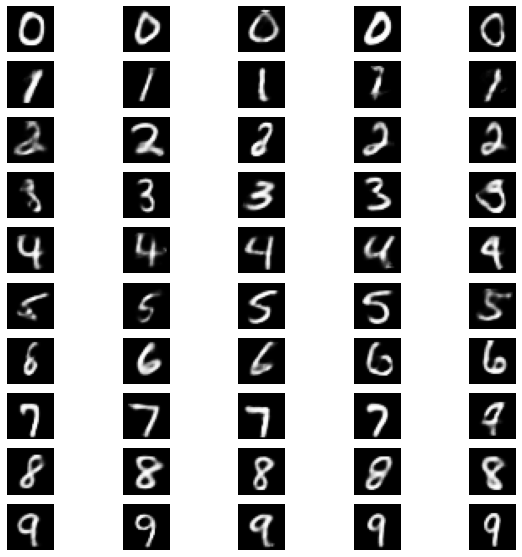

In [ ]:
cond_sampled_im_mean_np = sess.run(cond_sampled_im_mean)
# Show the sampled images.
plt.figure(figsize=(10, 10))
global_idx = 0
for digit in range(10):
    for _ in range(5):
        ax = plt.subplot(10, 5, global_idx + 1)
        plt.imshow(cond_sampled_im_mean_np[global_idx, :].reshape(28, 28), cmap='gray')
        ax.axis('off')
        global_idx += 1
plt.show()

# Лабораторная работа №2
Измените приведенный выше код для работы со смесью распределений Гаусса (в отличие от смеси биномиальных распределений) и повторите эксперименты с набором данных CIFAR-10, которые представляют собой полноцветные естественные изображения с гораздо более разнообразной структурой.

In [1]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate, BatchNormalization
from keras.models import Model, Sequential
from keras import metrics
from keras.datasets import mnist
from keras.utils import np_utils

import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [2]:
tf.__version__

'2.8.0'

In [3]:
# Start tf session so we can run code.
#sess = tf.InteractiveSession()
sess=tf.compat.v1.InteractiveSession()
# Connect keras to the created session.
K.set_session(sess)

In [4]:
from keras.datasets import cifar10
from PIL import Image
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
w_dim = x_train[0].shape[0]
h_dim = x_train[0].shape[1]
c_dim = x_train[0].shape[2]

170508288/170498071 [==============================] - 4s 0us/step


In [5]:
print(x_train[0].shape)

(32, 32, 3)


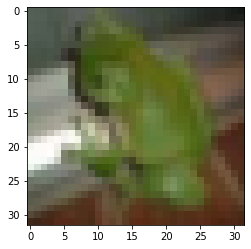

In [6]:
plt.imshow(x_test[7, :])
plt.show()

In [7]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)



In [8]:
x_train_ = x_train.astype('float32') / 255.
x_test_ = x_test.astype('float32') / 255.




x_train_ = x_train_.reshape(-1, w_dim * h_dim * c_dim)
x_test_ = x_test_.reshape(-1, w_dim * h_dim * c_dim)

In [9]:
x_train_[0]

array([0.23137255, 0.24313726, 0.24705882, ..., 0.48235294, 0.36078432,
       0.28235295], dtype=float32)

In [10]:
x_train_.shape

(50000, 3072)

In [11]:
y_test.shape

(10000, 10)

In [12]:
batch_size = 100
original_dim = x_train_.shape[1] # Number of pixels in MNIST images.
latent_dim = 10 # d, dimensionality of the latent code t.
intermediate_dim = 256 # Size of the hidden layer.
epochs = 50

x = Input(batch_shape=(batch_size, original_dim))


def create_encoder(input_dim):
    # Encoder network.
    # We instantiate these layers separately so as to reuse them later
    encoder = Sequential(name='encoder')
    encoder.add(InputLayer([input_dim]))
    #encoder.add(BatchNormalization())
    encoder.add(Dense(intermediate_dim, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal()))
    encoder.add(Dense(2 * latent_dim, kernel_initializer=tf.keras.initializers.GlorotNormal()))
    return encoder

    
encoder = create_encoder(original_dim)

get_t_mean = Lambda(lambda h: h[:, :latent_dim])
get_t_log_var = Lambda(lambda h: h[:, latent_dim:])


get_x_mean = Lambda(lambda h: h[:, :original_dim])
get_x_var = Lambda(lambda h: h[:, original_dim:])


h = encoder(x)
t_mean = get_t_mean(h)
t_log_var = get_t_log_var(h)

# Sampling from the distribution 
#     q(t | x) = N(t_mean, exp(t_log_var))
# with reparametrization trick.
def sampling(args):
    """Returns sample from a distribution N(args[0], diag(args[1]))
    
    The sample should be computed with reparametrization trick.
    
    The inputs are tf.Tensor
        args[0]: (batch_size x latent_dim) mean of the desired distribution
        args[1]: (batch_size x latent_dim) logarithm of the variance vector of the desired distribution
    
    Returns:
        A tf.Tensor of size (batch_size x latent_dim), the samples.
    """
    t_mean, t_log_var = args
    t_std = tf.exp(0.5*t_log_var)
    #print(t_std)
    eps = tf.random.normal(t_mean.shape, mean=0, stddev=1, dtype=tf.float32)*t_std + t_mean
    return eps

    # YOUR CODE HERE


t = Lambda(sampling)([t_mean, t_log_var])

def create_decoder(input_dim):
    # Decoder network
    # We instantiate these layers separately so as to reuse them later
    decoder = Sequential(name='decoder')
    decoder.add(InputLayer([input_dim]))
    decoder.add(Dense(intermediate_dim, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal()))
    decoder.add(Dense(2*original_dim, activation='sigmoid', kernel_initializer=tf.keras.initializers.GlorotNormal()))
    return decoder

    
decoder = create_decoder(latent_dim)
x_decoded = decoder(t)
x_decoded_mean = get_x_mean(x_decoded)
x_decoded_var = get_x_var(x_decoded)


In [13]:
def vlb_binomial(x, x_decoded_mean,  x_decoded_var, t_mean, t_log_var):
    """Returns the value of negative Variational Lower Bound
    
    The inputs are tf.Tensor
        x: (batch_size x number_of_pixels) matrix with one image per row with zeros and ones
        x_decoded_mean: (batch_size x number_of_pixels) mean of the distribution p(x | t), real numbers from 0 to 1
        t_mean: (batch_size x latent_dim) mean vector of the (normal) distribution q(t | x)
        t_log_var: (batch_size x latent_dim) logarithm of the variance vector of the (normal) distribution q(t | x)
    
    Returns:
        A tf.Tensor with one element (averaged across the batch), VLB
    """

    #cce = tf.keras.losses.CategoricalCrossentropy(axis=1)
    t_var =  tf.exp(t_log_var)
    kl = -t_log_var/2.0 + (t_var + t_mean**2 - 1)/2.0
    kl = tf.reduce_sum(kl, axis=1)
    batch_size = x.shape[0]
    number_of_pixels = x.shape[1]
    latend_dim = t_mean.shape[1]

    two_pi = tf.constant(2.0 * np.pi)      
    #log_p = tf.keras.losses.binary_crossentropy(x, x_decoded_mean)                                                                                                                        
    #log_p = -number_of_pixels/ 2.0 * tf.math.log(two_pi * tf.math.pow(x_decoded_var, 2.0) + 1e-6) -  tf.math.reduce_euclidean_norm(x_decoded_mean - x, axis=0) / (2.0 * tf.math.pow(x_decoded_var, 2.0)  + 1.0 * 1e-6)
    log_p = -0.5 * (tf.math.log(two_pi * tf.math.pow(x_decoded_var, 2.0) + 1e-6) +  tf.math.divide_no_nan(tf.math.reduce_euclidean_norm(x_decoded_mean - x, axis=0) , tf.math.pow(x_decoded_var, 2.0)))
    log_p = tf.reduce_sum(log_p, axis=1)

    #result = tf.reduce_mean(number_of_pixels*log_p - kl) 
    result = tf.reduce_mean(log_p - kl) 
    
    print("batch_size = {}, number_of_pixels = {} kl_size = {}".format(batch_size, number_of_pixels, kl.shape))
    return -result

batch_size = 100, number_of_pixels = 3072 kl_size = (100,)


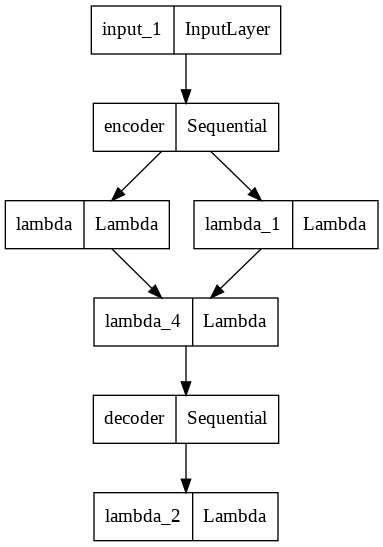

In [14]:
loss = vlb_binomial(x, x_decoded_mean, x_decoded_var, t_mean, t_log_var)
vae = Model(x, x_decoded_mean)
tf.keras.utils.plot_model(vae)

In [15]:
# hist = cvae.fit(x=[x_train_, y_train],
#                 y=[x_train_, y_train],
#                 shuffle=True,
#                 epochs=epochs,
#                 batch_size=batch_size,
#                 validation_data=([x_test_, y_test], [x_test_,  y_test]),
#                 verbose=2)

# Keras will provide input (x) and output (x_decoded_mean) to the function that
# should construct loss, but since our function also depends on other
# things (e.g. t_means), it is easier to build the loss in advance and pass
# a function that always returns it.
vae.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss=lambda x, y: loss)
#vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,\
#                amsgrad=False, name='Adam'), loss=lambda x, y: loss)

save_filepath = '/tmp_cifar/checkpoint'

hist = vae.fit(x=[x_train_, y_train],
                y=x_train_,
                shuffle=True,
                epochs=20,
                batch_size=batch_size,
                validation_data=([x_test_, y_test], x_test_), verbose=1, callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', mode = "min", verbose = 1, patience = 5)
                                                                                      , tf.keras.callbacks.ModelCheckpoint(filepath = save_filepath, monitor = 'val_loss', mode = 'min', verbose = 1, save_best_only=True)])

vae.load_weights(save_filepath)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - ETA: 0s - loss: 5987.0218

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 5411.33375, saving model to /tmp_cifar/checkpoint
INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets
50000/50000 [==============================] - 12s 243us/sample - loss: 5987.0218 - val_loss: 5411.3337
Epoch 2/20
49800/50000 [============================>.] - ETA: 0s - loss: 5360.6298
Epoch 2: val_loss improved from 5411.33375 to 5323.05614, saving model to /tmp_cifar/checkpoint
INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets
50000/50000 [==============================] - 4s 86us/sample - loss: 5360.1911 - val_loss: 5323.0561
Epoch 3/20
49700/50000 [============================>.] - ETA: 0s - loss: 5251.3066
Epoch 3: val_loss improved from 5323.05614 to 5236.23741, saving model to /tmp_cifar/checkpoint
INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets
50000/50000 [==============================] - 4s 81us/sample - loss: 5251.2978 - val_loss: 5236.2374
Epoch 4/20
49900/50000 [==========================

In [16]:
del vae

loss = vlb_binomial(x, x_decoded_mean, x_decoded_var, t_mean, t_log_var)
vae = Model(x, x_decoded_mean)


vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,\
                amsgrad=False, name='Adam'), loss=lambda x, y: loss)

save_filepath = '/tmp_cifar/checkpoint'
vae.load_weights(save_filepath)
hist2 = vae.fit(x=[x_train_, y_train],
                y=x_train_,
                shuffle=True,
                epochs=30,
                batch_size=batch_size,
                validation_data=([x_test_, y_test], x_test_), verbose=1, callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', mode = "min", verbose = 1, patience = 5)
                                                                                      , tf.keras.callbacks.ModelCheckpoint(filepath = save_filepath, monitor = 'val_loss', mode = 'min', verbose = 1, save_best_only=True)])
vae.load_weights(save_filepath)


batch_size = 100, number_of_pixels = 3072 kl_size = (100,)
Train on 50000 samples, validate on 10000 samples
Epoch 1/30
49400/50000 [============================>.] - ETA: 0s - loss: 5086.6833

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 5066.97247, saving model to /tmp_cifar/checkpoint
INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets
50000/50000 [==============================] - 4s 86us/sample - loss: 5086.4032 - val_loss: 5066.9725
Epoch 2/30
49200/50000 [============================>.] - ETA: 0s - loss: 5057.7352
Epoch 2: val_loss improved from 5066.97247 to 5061.73534, saving model to /tmp_cifar/checkpoint
INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets
50000/50000 [==============================] - 4s 86us/sample - loss: 5058.1491 - val_loss: 5061.7353
Epoch 3/30
49800/50000 [============================>.] - ETA: 0s - loss: 5053.0821
Epoch 3: val_loss improved from 5061.73534 to 5057.19209, saving model to /tmp_cifar/checkpoint
INFO:tensorflow:Assets written to: /tmp_cifar/checkpoint/assets
50000/50000 [==============================] - 4s 86us/sample - loss: 5053.0022 - val_loss: 5057.1921
Epoch 4/30
49100/50000 [============================

In [17]:
x_decoded_mean = vae.get_layer('decoder')

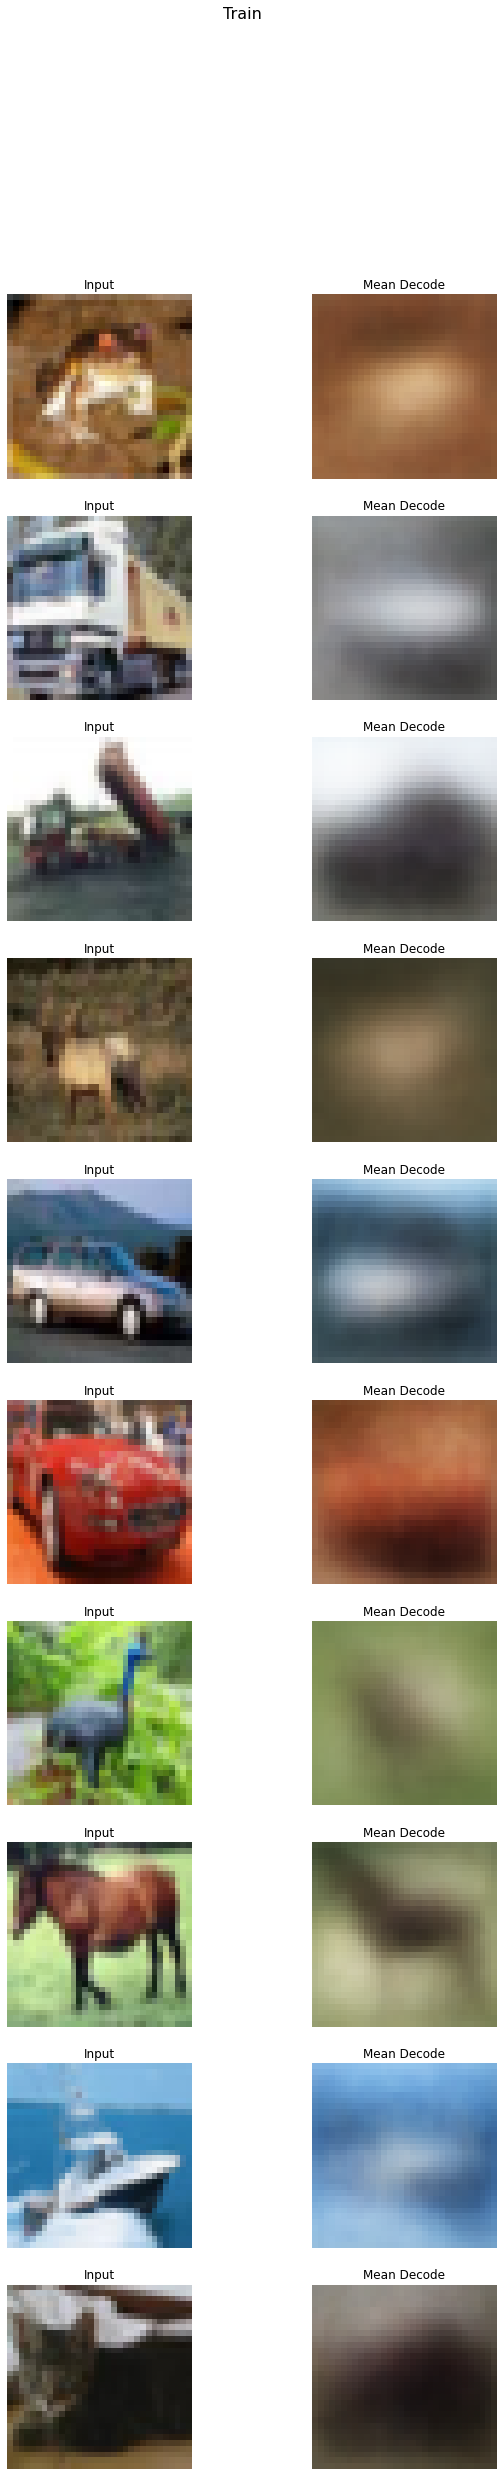

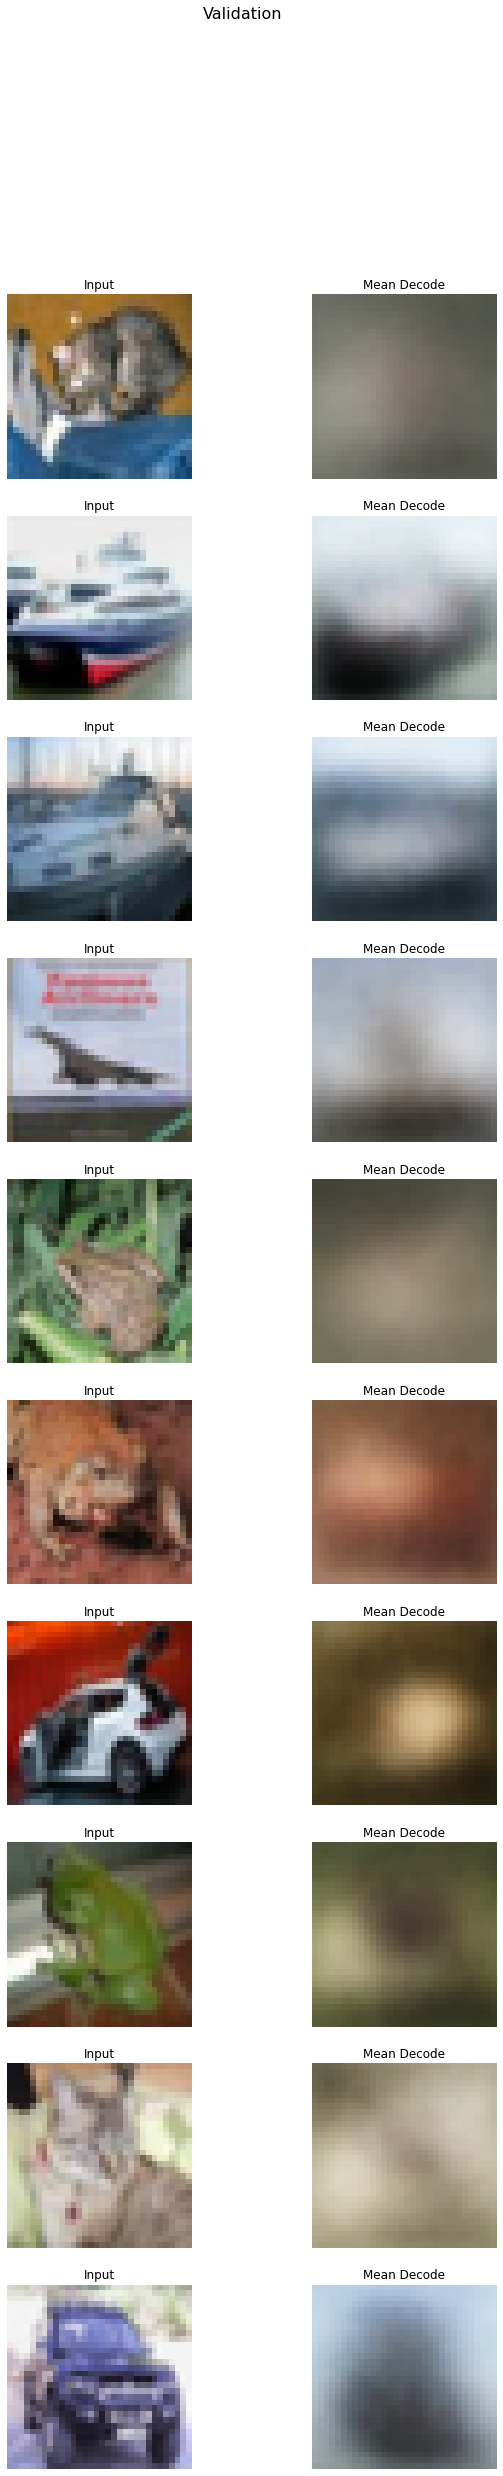

In [18]:

for fid_idx, (data, title) in enumerate(zip([x_train_, x_test_]
                                          , ['Train', 'Validation'])
                                        ):
    n = 10 
    fig, ax = plt.subplots(n, 2, figsize=(10, 4 * n))
    fig.suptitle(title, fontsize=16)
    ind = 0
    decoded = sess.run(get_x_mean(x_decoded), feed_dict={x: data[:batch_size, :]})
    for i in range(n):
        ax[i][0].imshow(data[i, :].reshape(w_dim, h_dim, c_dim))
        ax[i][1].imshow(decoded[i, :original_dim].reshape(w_dim, h_dim, c_dim))
        ax[i][0].set_title('Input')
        ax[i][1].set_title('Mean Decode')
        ax[i][0].axis('off')
        ax[i][1].axis('off')
plt.show()

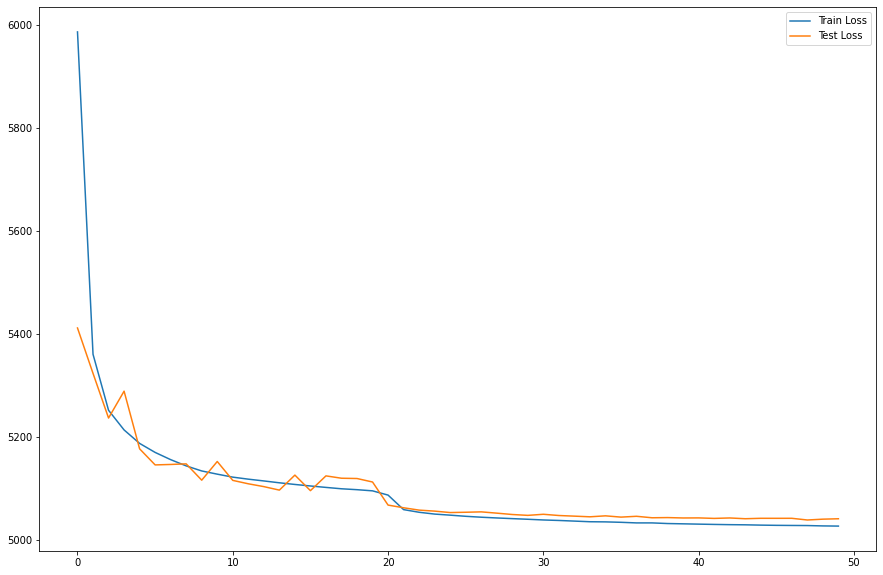

In [22]:
fig, ax = plt.subplots(figsize = (15, 10))


train_loss = np.concatenate([hist.history['loss'], hist2.history['loss']])

plt.plot(train_loss, label = 'Train Loss')


test_loss = np.concatenate([hist.history['val_loss'], hist2.history['val_loss']])

plt.plot(test_loss, label = 'Test Loss')
plt.legend()


**Обязательная часть**
* Повторить задание 1-4 для смеси распределений Гаусса (см. лекцию). Добавить раннюю остановку (early stopping)
* Получить выражение для VLB (Задание 1)
* Изучить влияние параметров на качество восстановления (Поварьировать параметры обучения, структуру сетей и пр.) 

**Дополнительно**
* Повторить задание 5
* Изучить влияние параметров на качество восстановления (Поварьировать параметры обучения, структуру сетей и пр.) 
* Реализовать для 1-5 сверточные слои в нейронной сети. Проанализировать результат.

# Тест с циферками

In [1]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate, BatchNormalization
from keras.models import Model, Sequential
from keras import metrics
from keras.datasets import mnist
from keras.utils import np_utils

import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [2]:
tf.__version__

'2.8.0'

In [3]:
# Start tf session so we can run code.
#sess = tf.InteractiveSession()
sess=tf.compat.v1.InteractiveSession()
# Connect keras to the created session.
K.set_session(sess)

In [4]:
from keras.datasets import cifar10
from PIL import Image
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# One hot encoding.
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape(len(x_train), -1)
x_test = x_test.reshape(len(x_test), -1)

In [5]:
print(y_train.shape)

(60000, 10)


In [6]:
print(x_train[0].shape)

(784,)


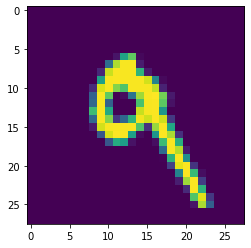

In [7]:
plt.imshow(x_test[7, :].reshape(28, 28))
plt.show()

In [8]:
batch_size = 10000
original_dim = 784 # Number of pixels in MNIST images.
latent_dim = 10 # d, dimensionality of the latent code t.
intermediate_dim = 256 # Size of the hidden layer.
epochs = 50

x = Input(batch_shape=(batch_size, original_dim))


def create_encoder(input_dim):
    # Encoder network.
    # We instantiate these layers separately so as to reuse them later
    encoder = Sequential(name='encoder')
    encoder.add(InputLayer([input_dim]))
    encoder.add(BatchNormalization())
    encoder.add(Dense(intermediate_dim, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal()))
    encoder.add(Dense(2 * latent_dim, kernel_initializer=tf.keras.initializers.GlorotNormal()))
    return encoder

    
encoder = create_encoder(original_dim)

get_t_mean = Lambda(lambda h: h[:, :latent_dim])
get_t_log_var = Lambda(lambda h: h[:, latent_dim:])


get_x_mean = Lambda(lambda h: h[:, :original_dim])
get_x_var = Lambda(lambda h: h[:, original_dim:])


h = encoder(x)
t_mean = get_t_mean(h)
t_log_var = get_t_log_var(h)

# Sampling from the distribution 
#     q(t | x) = N(t_mean, exp(t_log_var))
# with reparametrization trick.
def sampling(args):
    """Returns sample from a distribution N(args[0], diag(args[1]))
    
    The sample should be computed with reparametrization trick.
    
    The inputs are tf.Tensor
        args[0]: (batch_size x latent_dim) mean of the desired distribution
        args[1]: (batch_size x latent_dim) logarithm of the variance vector of the desired distribution
    
    Returns:
        A tf.Tensor of size (batch_size x latent_dim), the samples.
    """
    t_mean, t_log_var = args
    t_std = tf.exp(0.5*t_log_var)
    #print(t_std)
    eps = tf.random.normal(t_mean.shape, mean=0, stddev=1, dtype=tf.float32)*t_std + t_mean
    return eps

    # YOUR CODE HERE


t = Lambda(sampling)([t_mean, t_log_var])

def create_decoder(input_dim):
    # Decoder network
    # We instantiate these layers separately so as to reuse them later
    decoder = Sequential(name='decoder')
    decoder.add(InputLayer([input_dim]))
    decoder.add(Dense(intermediate_dim, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal()))
    decoder.add(Dense(2*original_dim, activation='sigmoid', kernel_initializer=tf.keras.initializers.GlorotNormal()))
    return decoder

    
decoder = create_decoder(latent_dim)
x_decoded = decoder(t)
x_decoded_mean = get_x_mean(x_decoded)
x_decoded_var = get_x_var(x_decoded)


Instructions for updating:
Colocations handled automatically by placer.


In [9]:
def vlb_binomial(x, x_decoded_mean,  x_decoded_var, t_mean, t_log_var):
    """Returns the value of negative Variational Lower Bound
    
    The inputs are tf.Tensor
        x: (batch_size x number_of_pixels) matrix with one image per row with zeros and ones
        x_decoded_mean: (batch_size x number_of_pixels) mean of the distribution p(x | t), real numbers from 0 to 1
        t_mean: (batch_size x latent_dim) mean vector of the (normal) distribution q(t | x)
        t_log_var: (batch_size x latent_dim) logarithm of the variance vector of the (normal) distribution q(t | x)
    
    Returns:
        A tf.Tensor with one element (averaged across the batch), VLB
    """

    #cce = tf.keras.losses.CategoricalCrossentropy(axis=1)
    t_var =  tf.exp(t_log_var)
    kl = -t_log_var/2.0 + (t_var + t_mean**2 - 1)/2.0
    kl = tf.reduce_sum(kl, axis=1)
    batch_size = x.shape[0]
    number_of_pixels = x.shape[1]
    latend_dim = t_mean.shape[1]

    two_pi = tf.constant(2.0 * np.pi)      
    #log_p = tf.keras.losses.binary_crossentropy(x, x_decoded_mean)                                                                                                                        
    #log_p = -number_of_pixels/ 2.0 * tf.math.log(two_pi * tf.math.pow(x_decoded_var, 2.0) + 1e-6) -  tf.math.reduce_euclidean_norm(x_decoded_mean - x, axis=0) / (2.0 * tf.math.pow(x_decoded_var, 2.0)  + 1.0 * 1e-6)
    log_p = -0.5 * (tf.math.log(two_pi * tf.math.pow(x_decoded_var, 2.0) + 1e-16) +  tf.math.divide_no_nan(tf.math.reduce_euclidean_norm(x_decoded_mean - x, axis=0) , tf.math.pow(x_decoded_var, 2.0)))
    log_p = tf.reduce_sum(log_p, axis=1)

    #result = tf.reduce_mean(number_of_pixels*log_p - kl) 
    result = tf.reduce_mean(log_p - kl) 
    
    print("batch_size = {}, number_of_pixels = {} kl_size = {}".format(batch_size, number_of_pixels, kl.shape))
    return -result

batch_size = 10000, number_of_pixels = 784 kl_size = (10000,)


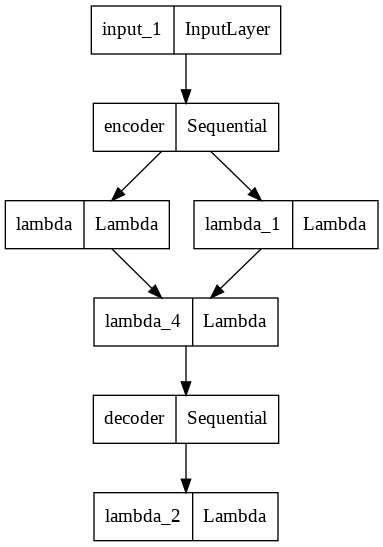

In [10]:



loss = vlb_binomial(x, x_decoded_mean, x_decoded_var, t_mean, t_log_var)
vae = Model(x, x_decoded_mean)
tf.keras.utils.plot_model(vae)

In [11]:
# hist = cvae.fit(x=[x_train_, y_train],
#                 y=[x_train_, y_train],
#                 shuffle=True,
#                 epochs=epochs,
#                 batch_size=batch_size,
#                 validation_data=([x_test_, y_test], [x_test_,  y_test]),
#                 verbose=2)

# Keras will provide input (x) and output (x_decoded_mean) to the function that
# should construct loss, but since our function also depends on other
# things (e.g. t_means), it is easier to build the loss in advance and pass
# a function that always returns it.
vae.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss=lambda x, y: loss)
#vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,\
   #             amsgrad=False, name='Adam'), loss=lambda x, y: loss)


hist = vae.fit(x=[x_train, y_train],
                y=x_train,
                shuffle=True,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=([x_test, y_test], x_test), verbose=1, callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', mode = "min", verbose = 1, patience = 10)
                                                                                      , tf.keras.callbacks.ModelCheckpoint(filepath = '/tmp/checkpoint', monitor = 'val_loss', mode = 'min', verbose = 1, save_best_only=True)])



Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - ETA: 0s - loss: 153090.5339

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 41396.27344, saving model to /tmp/checkpoint
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
60000/60000 [==============================] - 20s 336us/sample - loss: 153090.5339 - val_loss: 41396.2734
Epoch 2/50
60000/60000 [==============================] - ETA: 0s - loss: 20847.9375
Epoch 2: val_loss improved from 41396.27344 to 32025.18164, saving model to /tmp/checkpoint
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
60000/60000 [==============================] - 14s 239us/sample - loss: 20847.9375 - val_loss: 32025.1816
Epoch 3/50
60000/60000 [==============================] - ETA: 0s - loss: 14794.2323
Epoch 3: val_loss improved from 32025.18164 to 26541.42969, saving model to /tmp/checkpoint
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
60000/60000 [==============================] - 10s 166us/sample - loss: 14794.2323 - val_loss: 26541.4297
Epoch 4/50
60000/60000 [==============================] - ETA: 0s - 

In [12]:
vae.load_weights('/tmp/checkpoint')

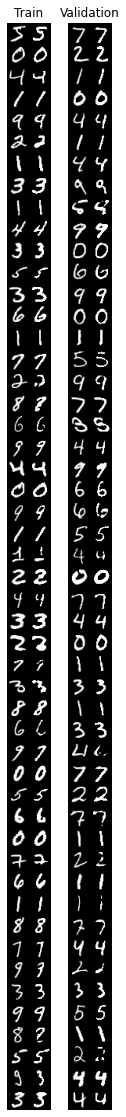

In [39]:
fig = plt.figure(figsize=(2, 20))
for fid_idx, (data, title) in enumerate(
            zip([x_train, x_test], ['Train', 'Validation'])):
    n = 50  # figure with 10 x 2 digits
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * 2))
    decoded = sess.run(x_decoded_mean, feed_dict={x: data[:batch_size, :original_dim]})
    for i in range(n):
        figure[i * digit_size: (i + 1) * digit_size,
               :digit_size] = data[i, :original_dim].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               digit_size:] = decoded[i, :original_dim].reshape(digit_size, digit_size).round()
    ax = fig.add_subplot(1, 2, fid_idx + 1)
    ax.imshow(figure,  cmap='gray')
    ax.set_title(title)
    ax.axis('off')
plt.show()

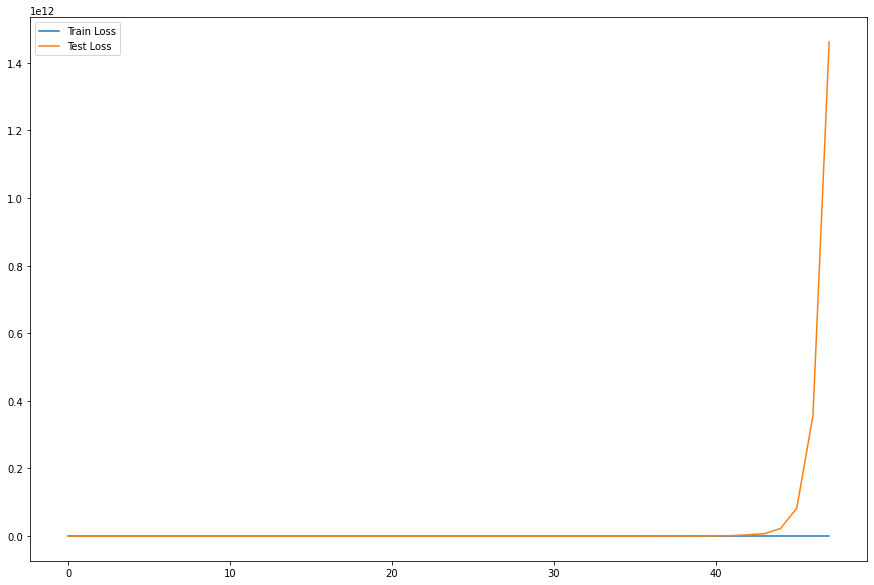

In [14]:
fig, ax = plt.subplots(figsize = (15, 10))


train_loss = hist.history['loss']

plt.plot(train_loss, label = 'Train Loss')


test_loss = hist.history['val_loss']

plt.plot(test_loss, label = 'Test Loss')
plt.legend()
